# Machine Learning Models

The aim of this notebook is to forecast COVID-19 time series using ML models. These models are 
ARIMA, Random Forest, Gradient Boosting for regression, SVR, KRR, KNN, GLM.

Target variables are:
1. Daily positive cases
2. Daily deaths
3. Hospital bed occupancy
4. ICU bed occupancy

The target variable used in this notebook will be `daily_cases`.

## Models

- [GLM](#GLM)
- [Random Forest](#RF)
- [Support Vector Regression](#SVR)
- [Kernel Ridge Regresor](#KRR)
- [KNN](#KNN)
- [Gradient Boosting Regressor](#GBR)
- [ARIMA](#ARIMA)

All models except the ARIMA model are not autoregressive, so it necessary to modify the target variable to create lagged obersvations in order to predict with these models at $n$ future instants in time. These models will try to find dependent relationships between the target at time $t+n$ and the features at time $t$. In contrast ARIMA model will try to use the dependent relationship between an observation and some number of lagged observations of the target variable.

## Setup

In [147]:
import os
from itertools import product
import pathlib
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from math import sqrt
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
import seaborn as sns
import time
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")



sys.path.insert(0, str(pathlib.Path.cwd().parent / 'src'))
from utils import Paths

## COVID-19 dataset

This project uses a covid-19 data from Cantabria (Spain) obtained from:

1. [Cantabria Health Service](https://www.scsalud.es/coronavirus).
2. [Cantabria Institute of Statistics](https://www.icane.es/covid19/dashboard/home/home) (ICANE).
3. [Ministry of Health, Consumer Affairs and Social Welfare](https://www.mscbs.gob.es).

To generate and process regional COVID-19 data from scratch use:
```bash
python src/data.py
python src/data.py --files covid
```
The dataset to be used is located in ./data/processed/covid/region/all_data_cantb.csv. This dataset contains 20 different features such as daily positive cases, daily deaths, hospital and ICU bed occupancy, daily pcr tests, 7-day and 14-day cumulative incidence and the number of people vaccinated. These were collected every day, beginning in 29 February 2020.

In [148]:
PATHS = Paths()
data_path = PATHS.processed / 'covid' / 'region' / 'all_data_cantb.csv'
df = pd.read_csv(data_path, sep=',').copy()

In [149]:
df = df.set_index('date')
df.tail(5)

,daily_cases,daily_deaths,cumulative_cases,cumulative_deaths,icu_occ,daily_antibody_tests,daily_antigen_tests,daily_pcr_tests,vaccinated_pp,hospital_occ,daily_total_tests,cases7,cases14,incidence7,incidence14,new_hospital_cases,new_icu_cases,daily_positivity
date,,,,,,,,,,,,,,,,,,
2021/08/03,226,2,41637,588,18,14,115,1597,339040,96,1726,1460,3619,252,623,1,0,0.130939
2021/08/04,182,0,41819,588,17,22,97,1468,348175,94,1587,1432,3517,247,606,0,0,0.114682
2021/08/05,319,1,42138,589,21,25,125,1823,350342,97,1973,1494,3414,258,588,3,4,0.161683
2021/08/06,183,0,42321,589,19,34,159,1460,353807,101,1653,1448,3349,250,577,4,0,0.110708
2021/08/07,83,0,42404,589,18,0,121,818,0,102,939,1340,3040,231,524,1,0,0.088392


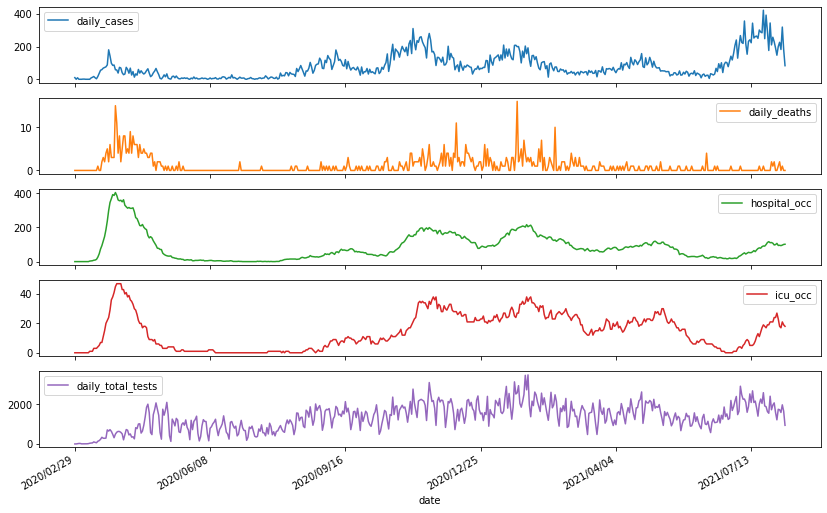

In [150]:
mpl.rcParams['figure.figsize'] = (14, 9)
mpl.rcParams['axes.grid'] = False

plot_cols = ['daily_cases', 'daily_deaths', 'hospital_occ', 'icu_occ', 'daily_total_tests']
plot_features = df[plot_cols]
plot_features.index = df.index
_ = plot_features.plot(subplots=True)

## Inspect
Next, look at the statistics of the dataset. All variables must be positive.

In [151]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
daily_cases,526.0,80.777567,74.811674,0.0,26.250000,60.000000,114.750000,422.0
daily_deaths,526.0,1.123574,1.968789,0.0,0.000000,0.000000,1.000000,16.0
cumulative_cases,526.0,15846.741445,12587.817314,1.0,3108.750000,14881.000000,27161.500000,42404.0
cumulative_deaths,526.0,345.437262,178.013918,0.0,211.000000,291.500000,547.000000,589.0
icu_occ,526.0,14.256654,11.988117,0.0,2.000000,12.000000,23.750000,47.0
daily_antibody_tests,526.0,84.068441,163.308435,0.0,0.000000,38.500000,83.000000,1284.0
daily_antigen_tests,526.0,39.359316,47.013779,0.0,0.000000,0.000000,73.000000,245.0
daily_pcr_tests,526.0,1243.619772,637.336738,0.0,743.750000,1273.500000,1726.250000,3307.0
vaccinated_pp,526.0,30053.268061,74238.952101,0.0,0.000000,0.000000,0.000000,353807.0
hospital_occ,526.0,85.391635,78.953336,1.0,24.000000,70.000000,121.000000,403.0


The processing of the data has been done before when the dataset has been generated.

## Split and normalize the data
I will use a `(80%, 15%, 5%)` split for the training, validation, and test sets. The data is **not** being randomly shuffled before splitting because:

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

Normalization is a common way of doing this scaling: subtract the mean and divide by the standard deviation of each feature.

In [152]:
def make_splits(df,
                target,
                time_step=0,
                ntrain=0.8,
                nval=0.15,
                ntest=0.05):
    """
    Split the dataframe in train, validation and test dataframe.
    For models not autoregressive, it is necessary to modify the target variable to create lagged 
    obersvations in order to predict the n future instants. 
    These models will try to find dependent relationships between the target y(t+n) and the features x(t). 
    
    Args:
        df: DataFrame
        target: Target variable.
        time_step: Number of lags.
        ntrain: Size for the training dataframe.
        nval: Size for the validation dataframe.
        ntest: Size for the test dataframe.

    Returns: Dict splited into training, validation and test dataframe. Also into features and target.
            {train:{X: , y: }, val:{X: , y: }, test:{X: , y: }}

    """
    # Target variable
    df = df.copy()
    y_target = df[target].shift(-int(time_step))
    target_t = f'{target}_(t+{time_step})'
    df[target_t] = y_target
    df = df.drop(columns=[target])
    # Keep only rows with non-NANs
    df = df[~df.isna().any(axis='columns')]
    
    # split into train, val, test datasets.
    n = len(df)
    train_df = df[0:int(n * ntrain)]
    val_df = df[int(n * ntrain):int(n * (ntrain + nval))]
    test_df = df[int(n * (1-ntest)):]
    # split into features and target variables.
    X_train = train_df.drop(columns=target_t)
    X_val = val_df.drop(columns=target_t)
    X_test = test_df.drop(columns=target_t)
    y_train = train_df[target_t]
    y_val = val_df[target_t]
    y_test = test_df[target_t]
    
    splits_df = {'train': {}, 'val': {}, 'test': {}}
    splits_df['train']['X'] = X_train
    splits_df['train']['y'] = y_train
    splits_df['val']['X'] = X_val
    splits_df['val']['y'] = y_val
    splits_df['test']['X'] = X_test
    splits_df['test']['y'] = y_test
    
    return splits_df

In [153]:
def normalize(splits):
    """
    Normalize training, validation and test dataframe.
    Before training a deep learning model, it is important to scale features. Normalization is a common way of doing
    this scaling: subtract the mean and divide by the standard deviation of each feature.

    Note: The mean and standard deviation should only be computed using the training data so that the models have no
            access to the values in the validation and test sets.

    Args:
        splits: Dictionary with training, validation and test dataframe without normalization.

    Returns: Dictionary with training, validation and test dataframe after normalization. 
            And the mean and std used in the process.

    """
    mean = splits['train']['X'].mean()
    std = splits['train']['X'].std()

    for i in ['train', 'val', 'test']:
        splits[i]['X'] = (splits[i]['X'] - mean) / std
    
    norm = pd.DataFrame([mean, std], index=['mean', 'std']).T
            
    return splits, norm

In [154]:
def denormalize(splits, norm):
    """
    Denormalize training, validation and test dataframe.
    Args:
        splits: Dictionary with training, validation and test normalized dataframe.
        norm: DataFrame with the parameters used in normalization process.

    Returns: Dictionary with training, validation and test dataframe before normalization.

    """
    mean = norm['mean']
    std = norm['std']

    for i in ['train', 'val', 'test']:
        splits[i]['X'] = splits[i]['X'] * std + mean
               
    return splits

## Choose target variable

In [155]:
# Split and define target variable
split_df = make_splits(df, target='daily_cases', time_step=7, ntrain=0.85, nval=0.1, ntest=0.05)

In [156]:
# Normalize data
split_ndf, norm = normalize(split_df)

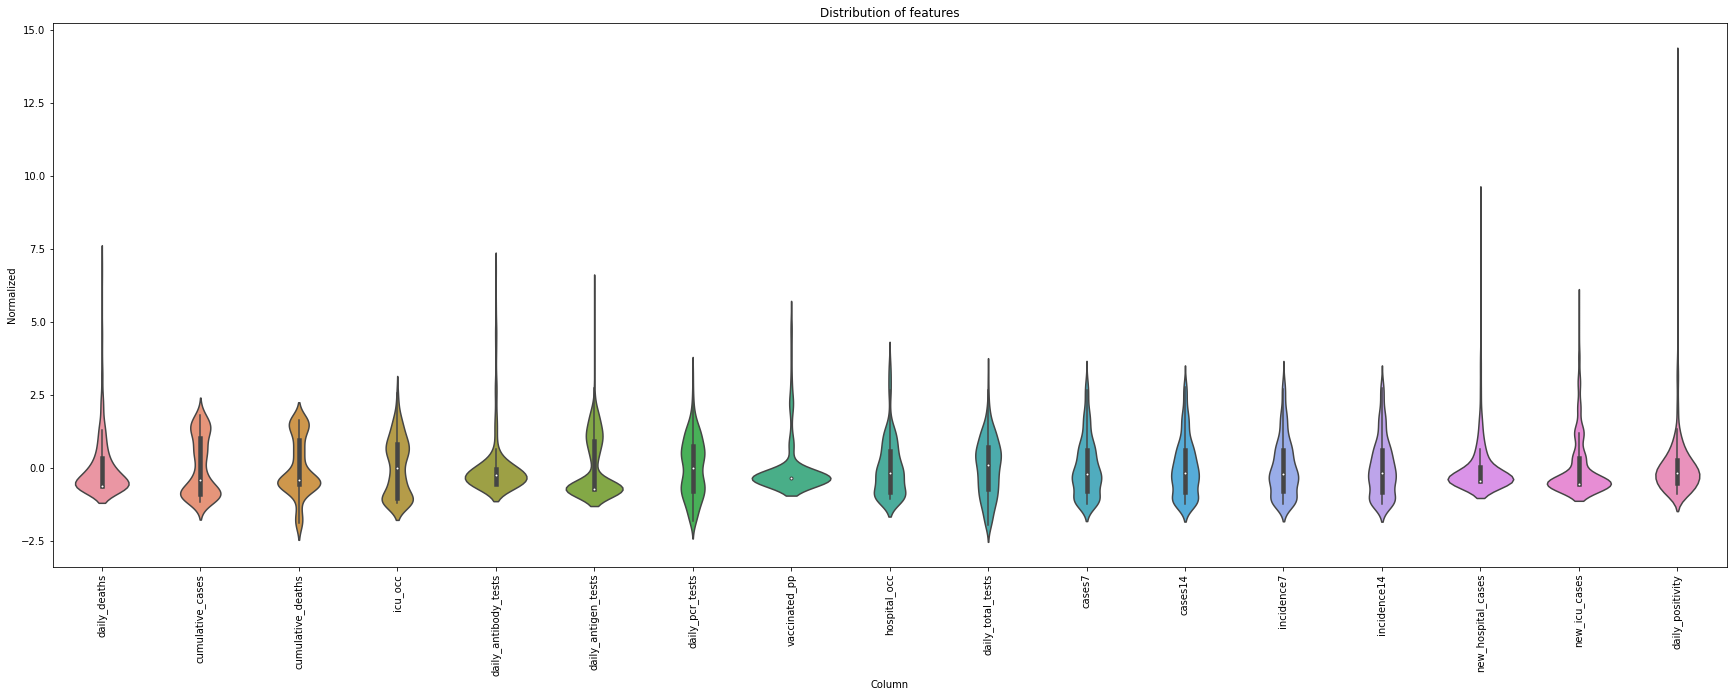

In [157]:
# Plot distribution of features
df_std = split_ndf['train']['X']
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(30, 10))
plt.title('Distribution of features')
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(split_ndf['train']['X'].keys(), rotation=90)

## Models 

After fitting the models, it is useful assessing prediction error.

In [235]:
def model_summary(model, splits):
    """
    Calculate predictions and evaluate the errors with some metrics .
    Calculate the Mean Absolute Error, Mean Absolute Percentage Error, Mean Square Erro and R^2 score.
    
    Args:
        model: Trained model used to predict.
        splits: Dictionary with training, validation and test data. 
    
    Return: Dictionary with the metrics of each dataframe (train, val, test).
    """

    metrics = {'rmse': {}, 'mse': {}, 'mae': {}, 'mape': {}, 'r2': {}}

    for i in ['train', 'val', 'test']:
        x_t = splits[i]['X']
        y_t = splits[i]['y']
        
        try:
            if len(x_t) != 0:
                y_p = model.predict(x_t) 

                # Metrics
                mse = mean_squared_error(y_true=y_t,
                                         y_pred=y_p,
                                         squared=False)
                rmse = sqrt(mse)
                mae = mean_absolute_error(y_true=y_t,
                                          y_pred=y_p)
                mape = mean_absolute_percentage_error(y_true=y_t,
                                                      y_pred=y_p)
                r2 = r2_score(y_t, y_p)
                
                metrics['rmse'][i] = rmse
                metrics['mae'][i] = mae
                metrics['mape'][i] = mape
                metrics['mse'][i] = mse
                metrics['r2'][i] = r2
                
                df_metrics = pd.DataFrame.from_dict(metrics, orient='index')
                
        except Exception as e:
            print(e)

    return metrics, df_metrics

In [236]:
def model_plot(model, splits):
    """
    Calculate predictions and evaluate the errors with some metrics.
    Calculate the Mean Absolute Error, Mean Absolute Percentage Error, Mean Square Erro and R^2 score.
    
    Args:
        model: Trained model used to predict.
        splits: Dictionary with training, validation and test data. 
    
    Return: Dictionary with the metrics of each dataframe (train, val, test).
    """

    for index, i in enumerate(['train', 'val', 'test']):
        x_t = splits[i]['X']
        y_t = splits[i]['y']
        
        try:
            if len(x_t) != 0:
                y_p = model.predict(x_t) 
                
                # Plots
                plt.subplot(3, 1, index+1)
                y_t.plot()
                plt.plot(y_p, color='red')
                plt.title(f'Model fit {i}')
                plt.ylabel(y_t.name)
                plt.xlabel('Time, t [days]')
                plt.legend(['Data', 'Forecast'], loc='upper left')
                plt.show()
        except Exception as e:
            print(e)

In [287]:
# Features
X_train = split_ndf['train']['X']
# Target
y_train = split_ndf['train']['y']
# Metrics
metrics = {}

### GLM<a name="GLM"></a>

Generalized Linear Models currently supports estimations using the one-parameter exponential families.

In [161]:
t0 = time.time()
glm_model = sm.GLM(y_train, X_train, family=sm.families.Gaussian())
glm_model = glm_model.fit()
print('Elapsed time: ', time.time() - t0, '(s)')
# glm_model.summary()

Elapsed time:  0.017661094665527344 (s)


In [288]:
_, glm_metrics = model_summary(glm_model, split_ndf)
metrics['GLM'] = glm_metrics

In [290]:
glm_metrics

,train,val,test
rmse,8.840098e+00,8.869479,13.190963
mse,7.814733e+01,78.667657,174.001497
mae,7.113740e+01,74.149519,157.255145
mape,3.793557e+15,2.110002,0.921788
r2,-6.415161e-01,-6.388577,-2.696988


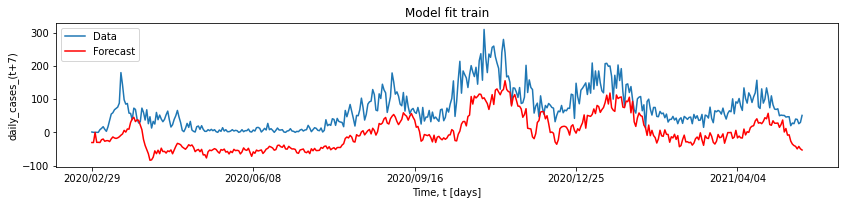

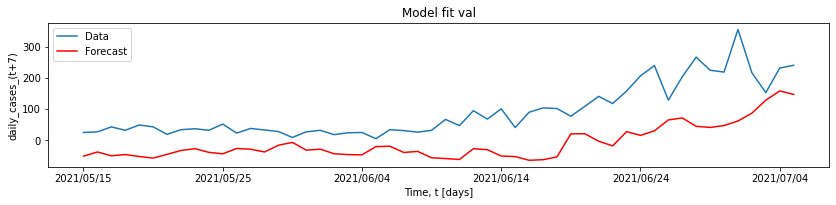

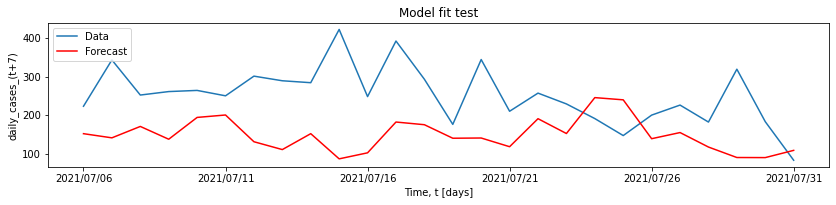

In [164]:
model_plot(glm_model, split_ndf)

### Random Forest<a name="RF"></a>

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predicitive accuracy and control over-fitting.

In [241]:
# Data
split_df = make_splits(df, target='daily_cases', time_step=7, ntrain=0.85, nval=0.1, ntest=0.05)
split_ndf, norm = normalize(split_df)
# Features
X_train = split_ndf['train']['X']
# Target
y_train = split_ndf['train']['y']

In [166]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 80, 90, 100, 110],
    'max_features': [1, 2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [4, 6, 8, 10, 12],
    'n_estimators': [5, 10, 50, 100, 200, 300, 1000]}

rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, 
                           param_grid = param_grid, 
                           n_jobs = -1, 
                           cv = 3,
                           verbose = 2)

In [167]:
# Search best model
t0 = time.time()
models = grid_search.fit(X_train, y_train)
print('Elapsed time: ', time.time() - t0, '(s)')

Fitting 3 folds for each of 7560 candidates, totalling 22680 fits
Elapsed time:  2244.4645063877106 (s)


In [168]:
# Best parameters for our model
best_grid = models.best_params_
best_grid

{'bootstrap': False,
 'max_depth': 20,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 5}

In [242]:
# Fit best model
t0 = time.time()
rf_model = RandomForestRegressor(n_estimators=5,
                                 criterion='mae', 
                                 max_depth=20, 
                                 max_features=3, 
                                 min_samples_leaf=3, 
                                 min_samples_split=10, 
                                 bootstrap=False)
rf_model = rf_model.fit(X_train, y_train)
print('Elapsed time: ', time.time() - t0, '(s)')

Elapsed time:  0.030930280685424805 (s)


In [291]:
_, rf_metrics = model_summary(rf_model, split_ndf)
metrics['RF'] = rf_metrics

In [244]:
rf_metrics

,train,val,test
rmse,3.924495e+00,8.064402,11.459418
mse,1.540166e+01,65.034583,131.318267
mae,9.520181e+00,45.480769,112.903846
mape,2.083298e+14,0.728954,0.416515
r2,9.334414e-01,0.391591,-2.163548


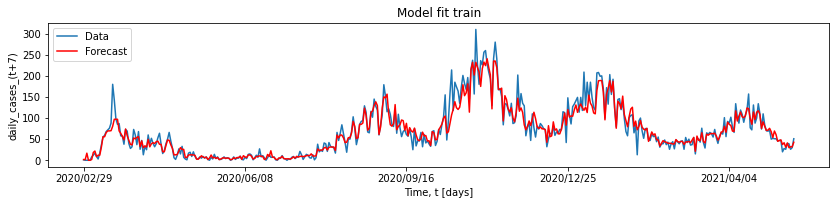

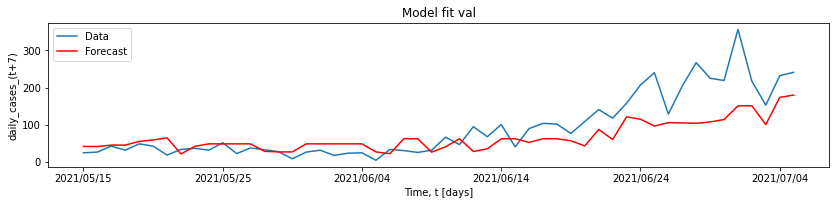

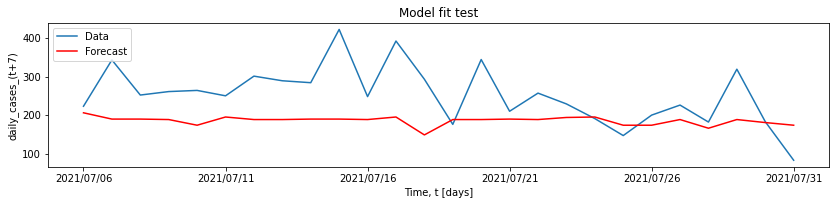

In [228]:
model_plot(rf_model, split_ndf)

### Support Vector Regression (SVR)<a name="SVR"></a>
SVR is built based on the concept of Support Vector Machine (SVM). SVR gives us the flexibility to define how much error is acceptable in our model. The free parameters in the model are C and $\epsilon$ to choose how tolerant the model will be of errors, both through an acceptable error margin and through tuning our tolerance of falling outside that acceptable error rate.

In [245]:
# Data
split_df = make_splits(df, target='daily_cases', time_step=7, ntrain=0.8, nval=0.1, ntest=0.1)
split_ndf, norm = normalize(split_df)
# Features
X_train = split_ndf['train']['X']
# Target
y_train = split_ndf['train']['y']

In [174]:
param_grid={"C": [1e-1, 1e0, 1e1, 1e2],
            "epsilon": [0.05, 0.1, 0.5, 1, 5, 10, 20],
            "gamma": np.logspace(-2, 2, 5),
            "kernel": ['rbf', 'sigmoid']}

# Create the model
svr = SVR(kernel='rbf')
grid_search = GridSearchCV(estimator = svr, 
                           param_grid = param_grid, 
                           n_jobs = -1, 
                           cv = 5,
                           verbose = 2)

In [175]:
# Search best model
t0 = time.time()
models = grid_search.fit(X_train, y_train)
print('Elapsed time: ', time.time() - t0, '(s)')

Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Elapsed time:  9.552810907363892 (s)


In [176]:
# Best parameters for our model
best_grid = models.best_params_
best_grid

{'C': 100.0, 'epsilon': 5, 'gamma': 0.01, 'kernel': 'rbf'}

In [247]:
# Fit best model
t0 = time.time()
svr_model = SVR(kernel='rbf',
                gamma=0.01,
                epsilon=5,
                C=100)
svr_model = svr_model.fit(X_train, y_train)
print('Elapsed time: ', time.time() - t0, '(s)')

Elapsed time:  0.014118194580078125 (s)


In [292]:
_, svr_metrics = model_summary(svr_model, split_ndf)
metrics['SVR'] = svr_metrics
svr_metrics

,train,val,test
rmse,5.505051e+00,6.582154,13.119313
mse,3.030558e+01,43.324751,172.116371
mae,2.046567e+01,38.404946,140.679812
mape,5.518865e+14,1.271319,0.623447
r2,7.531335e-01,-1.240993,-2.617316


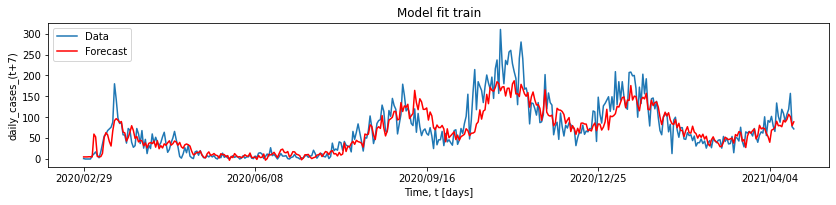

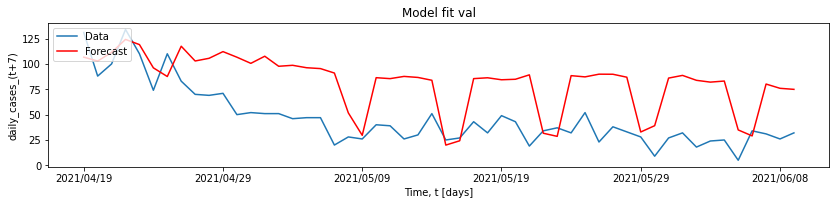

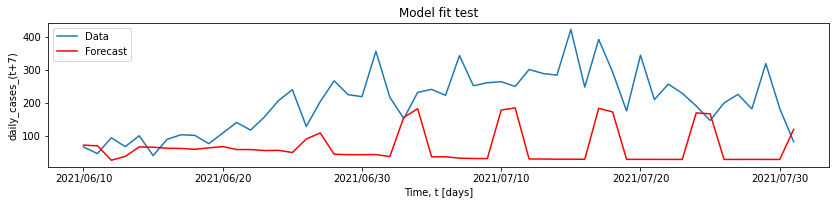

In [232]:
model_plot(svr_model, split_ndf)

### Kernel Ridge Regression (KRR)<a name="KRR"></a>

Kernel ridge regression (KRR) combines ridge regression (linear least squares with L2-norm regularization) with the kernel trick.

Both KRR and SVR learn a non-linear function by emplying the kernel trick. They differ in the loss functions (ridge verse epsilon-insensitive loss). In contrast to SVR, fitting a KRR can be done in closed-form and is typically faster for medium-sized datasets. On the other hand, the learned model is non-sparse and thus slower than SVR at prediction-time.

In [293]:
# Data
split_df = make_splits(df, target='daily_cases', time_step=7, ntrain=0.8, nval=0.1, ntest=0.1)
split_ndf, norm = normalize(split_df)
# Features
X_train = split_ndf['train']['X']
# Target
y_train = split_ndf['train']['y']

In [181]:
param_grid = {"alpha": [30, 10, 1e0, 0.1, 1e-2, 1e-3],
              "gamma": np.logspace(-4, 2, 7),
              "kernel": ['rbf', 'sigmoid'],
              "coef0": [1, 2, 5, 10]}
# Create the model
krr = KernelRidge(kernel='sigmoid')
grid_search = GridSearchCV(estimator = krr, 
                           param_grid = param_grid, 
                           n_jobs = -1, 
                           cv = 5,
                           verbose = 2)

In [182]:
# Search best model
t0 = time.time()
models = grid_search.fit(X_train, y_train)
print('Elapsed time: ', time.time() - t0, '(s)')

Fitting 5 folds for each of 336 candidates, totalling 1680 fits
Elapsed time:  10.959429502487183 (s)


In [183]:
# Best parameters for our model
best_grid = models.best_params_
best_grid

{'alpha': 0.1, 'coef0': 1, 'gamma': 0.01, 'kernel': 'rbf'}

In [184]:
# Best model
t0 = time.time()
krr_model = KernelRidge(kernel='rbf',
                        alpha=0.1,
                        gamma=0.01)
krr_model = krr_model.fit(X_train, y_train)
print('Elapsed time: ', time.time() - t0, '(s)')

Elapsed time:  0.021947383880615234 (s)


In [294]:
_, krr_metrics = model_summary(krr_model, split_ndf)
metrics['KRR'] = krr_metrics
krr_metrics

,train,val,test
rmse,5.163091e+00,6.836546,13.720931
mse,2.665751e+01,46.738356,188.263940
mae,1.885326e+01,41.703661,151.212468
mape,6.358276e+14,1.410506,0.668205
r2,8.089901e-01,-1.608046,-3.327892


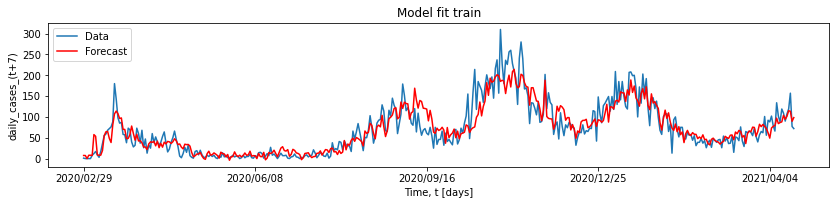

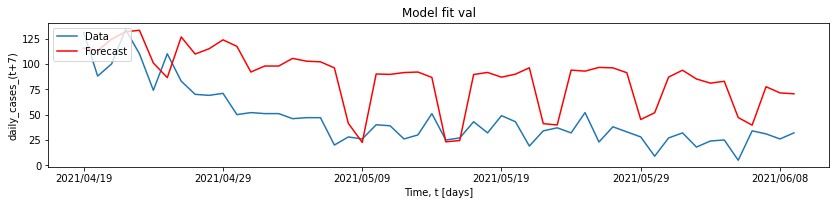

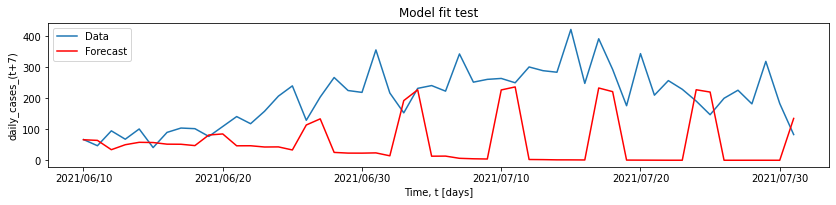

In [186]:
model_plot(krr_model, split_ndf)

### KNN<a name="KNN"></a>

K-Nearest-Neighbor algorithm can be used for classification and regression. It uses feature similarity to predict the values of any new data points.

In [295]:
# Data
split_df = make_splits(df, target='daily_cases', time_step=7, ntrain=0.8, nval=0.1, ntest=0.1)
split_ndf, norm = normalize(split_df)
# Features
X_train = split_ndf['train']['X']
# Target
y_train = split_ndf['train']['y']

In [256]:
param_grid = {"n_neighbors": list(range(1, 30, 1))}
# Create the model
knn = KNeighborsRegressor()
grid_search = GridSearchCV(estimator = knn, 
                           param_grid = param_grid, 
                           n_jobs = -1, 
                           cv = 5,
                           verbose = 4)

In [257]:
# Search best model
t0 = time.time()
models = grid_search.fit(X_train, y_train)
print('Elapsed time: ', time.time() - t0, '(s)')

Fitting 5 folds for each of 29 candidates, totalling 145 fits
Elapsed time:  2.950261354446411 (s)


In [258]:
# Best parameters for our model
best_grid = models.best_params_
best_grid

{'n_neighbors': 19}

In [259]:
# Best model
t0 = time.time()
knn_model = KNeighborsRegressor(n_neighbors=19)
knn_model = knn_model.fit(X_train, y_train)
print('Elapsed time: ', time.time() - t0, '(s)')

Elapsed time:  0.0019881725311279297 (s)


In [296]:
_, knn_metrics = model_summary(knn_model, split_ndf)
metrics['KNN'] = knn_metrics
knn_metrics

,train,val,test
rmse,5.764567e+00,6.779112,11.862436
mse,3.323023e+01,45.956361,140.717377
mae,2.346747e+01,42.480769,116.133603
mape,1.662648e+15,1.549977,0.522882
r2,7.031866e-01,-1.521504,-1.417896


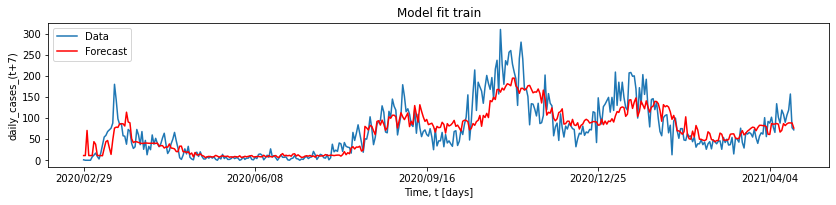

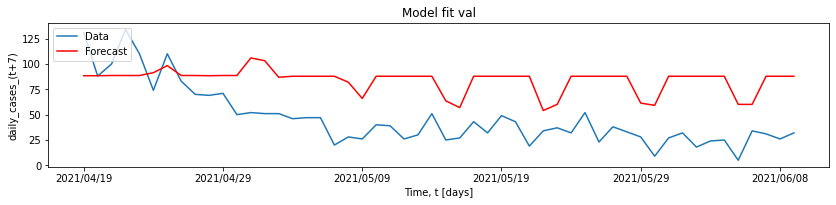

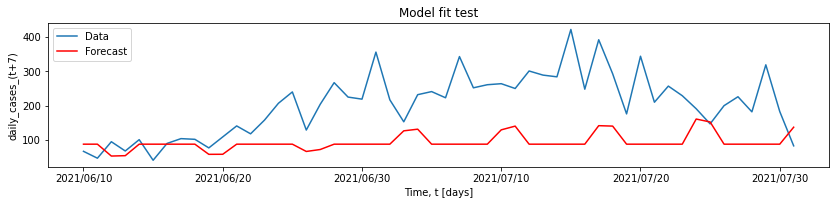

In [261]:
model_plot(knn_model, split_ndf)

### Gradient Boosting Regressor<a name="GBR"></a>

Gradient Boosting (GB) for regression builds an additive model in a forward stage-wise fashion. It allows for the optimization of arbitrary differentiable loss functions. In each stage a regression tree is fit on the negative gradient of the given loss function.

In [297]:
# Data
split_df = make_splits(df, target='daily_cases', time_step=7, ntrain=0.8, nval=0.1, ntest=0.1)
split_ndf, norm = normalize(split_df)
# Features
X_train = split_ndf['train']['X']
# Target
y_train = split_ndf['train']['y']

In [263]:
param_grid = {"n_estimators": [5, 10, 50, 100, 200, 300, 1000],
              "learning_rate": [0.05, 0.1, 0.2, 0.4, 0.6, 0.8],
              "max_depth": [10, 20, 30, 40, 50, 80, 90, 100, 110],}

# Create the model
gb = GradientBoostingRegressor(random_state=0, loss='ls')
grid_search = GridSearchCV(estimator = gb, 
                           param_grid = param_grid, 
                           n_jobs = -1, 
                           cv = 5,
                           verbose = 4)

In [265]:
# Search best model
t0 = time.time()
models = grid_search.fit(X_train, y_train)
print('Elapsed time: ', time.time() - t0, '(s)')

Fitting 5 folds for each of 378 candidates, totalling 1890 fits
Elapsed time:  314.12694931030273 (s)


In [270]:
# Best parameters for our model
best_grid = models.best_params_
best_grid

{'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 5}

In [271]:
# Best model
t0 = time.time()
gb_model = GradientBoostingRegressor(n_estimators=5,
                                     learning_rate=0.2,
                                     max_depth=10,
                                     random_state=0,
                                     loss='ls')
gb_model = gb_model.fit(X_train, y_train)
print('Elapsed time: ', time.time() - t0, '(s)')

Elapsed time:  0.02692890167236328 (s)


In [298]:
_, gb_metrics = model_summary(gb_model, split_ndf)
metrics['GB'] = gb_metrics
gb_metrics

,train,val,test
rmse,4.490345e+00,5.819532,10.543072
mse,2.016320e+01,33.866955,111.156362
mae,1.590666e+01,30.958894,88.686040
mape,2.350408e+15,1.117772,0.403036
r2,8.907213e-01,-0.369370,-0.508727


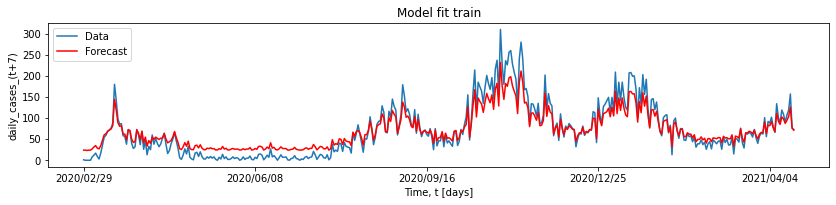

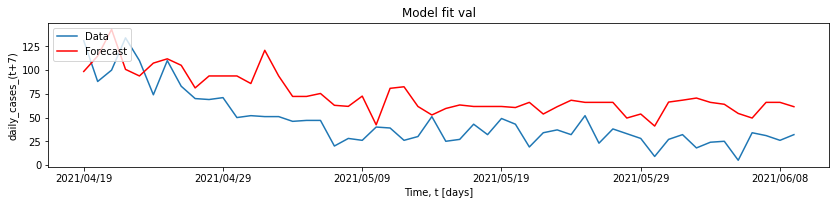

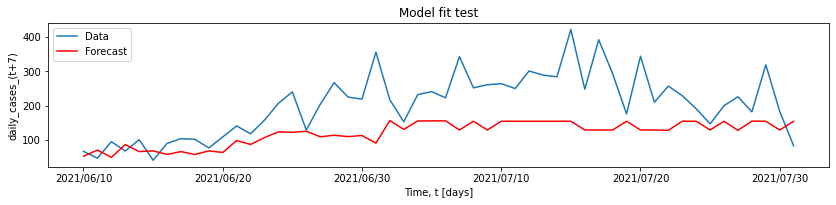

In [273]:
model_plot(gb_model, split_ndf)

### ARIMA<a name="ARIMA"></a>

An ARIMA model is a class of statistical models for analyzing and forecasting time series data. 
* __AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations__.
* I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
* MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

The parameters of the ARIMA model are defined as follows:

* p: The number of lag observations included in the model, also called the lag order.
* d: The number of times that the raw observations are differenced, also called the degree of differencing.
* q: The size of the moving average window, also called the order of moving average.

A value of 0 can be used for a parameter, which indicates to not use that element of the model. This way, the ARIMA model can be configured to perform the function of an ARMA model, and even a simple AR, I, or MA model.

In [201]:
def evaluate_arima_model(splits, arima_order):
    """
    Evaluate an ARIMA model for a given order (p,d,q) and also forecast the next one time step.
    Train the model using t = (1, ..., t) and predict next time step (t+1).
    Then add (t+1) value from test dataset to history and fit again the model using t = (1, ..., t, t+1)
    to predict the next instant (t+2), and so on up to t=N where N=len(test)
    Finally, with the predictions and observables from the test dataset, the metrics MSE, MAE, MAPE y R2
    are calculated.
    Args:
        splits: Dictionary with training, validation and test data. 
        arima_order: Tuple. Contains the argument p, d, q for ARIMA model.
       

    Returns: Errors from predictions using previous iterations.

    """
    try:
        # prepare training and test dataset (validation+test)
        train = splits['train']['y'].astype('float32')
        val_y = splits['val']['y'].astype('float32')
        test_y = splits['test']['y'].astype('float32')
        test = pd.concat([val_y, test_y])

        history = [x for x in train]
        predictions = list()

        for t in range(len(test)):
            model = sm.tsa.ARIMA(history, order=arima_order)
            model_fit = model.fit(dis=-1)  # All cores
            yhat = model_fit.forecast()[0]  # Predict one step in future from the last value in history variable.
            predictions.append(yhat)
            history.append(test[t])

        # Metrics
        mse = mean_squared_error(test, predictions)
        rmse = sqrt(mean_squared_error(test, predictions))
        mae = mean_absolute_error(test, predictions)
        mape = mean_absolute_percentage_error(test, predictions)
        r2 = r2_score(test, predictions)
        
        return arima_order, rmse, mse, mae, mape, r2
        
    except Exception as e:
        pass

In [202]:
def my_map(fun1, obj, iterlist):
    """
    Map() function with a non-iterable and iterable set of parameters.
    Args:
        fun1: Function to use with 2 arguments (obj, element)
        obj: Non iterable or constant object.
        iterlist: List of elements to iterate.

    Returns: Return list from map(func1, obj_cte, iterlist)

    """
    def fun2(x):
        """
        Apply function 1.
        Args:
            x: Element of a list
        Returns: The return from function 1
        """
        return fun1(obj, x)
    return map(fun2, iterlist)

In [203]:
# Data with time_step=0
split_df = make_splits(df, target='daily_cases', time_step=0, ntrain=0.85, nval=0, ntest=0.15)
split_ndf, norm = normalize(split_df)

In [204]:
# Evaluated parameters
p = [0, 1, 2, 4, 6, 8, 10]
d = range(0, 3)
q = range(0, 3)
parameters = product(p, d, q)
parameters_list = list(parameters)

In [205]:
from tqdm import tqdm
# Search best combination of parameters (p, d, q)
t0 = time.time()
result = list(my_map(evaluate_arima_model, split_ndf, tqdm(parameters_list)))
print('Elapsed time: ', time.time() - t0, '(s)')

100%|████████████████████████████████████████████████████████████████████████████████| 63/63 [1:22:19<00:00, 78.41s/it]

Elapsed time:  4939.797879457474 (s)


In [206]:
result = pd.DataFrame(result,
                      columns=['(p, d, p)', 'RMSE', 'MSE', 'MAE', 'MAPE', 'R2'])
result_sort = result.sort_values(by='RMSE', ascending=True).reset_index(drop=True)
result_sort = result_sort.dropna()
result_sort.head()

,"(p, d, p)",RMSE,MSE,MAE,MAPE,R2
0,"(4, 1, 2)",48.307096,2333.575557,32.779880,0.324064,0.807806
1,"(6, 1, 2)",49.004950,2401.485085,33.570288,0.322323,0.802213
2,"(8, 0, 2)",49.035264,2404.457156,33.707426,0.329808,0.801968
3,"(10, 1, 2)",49.272728,2427.801754,34.221040,0.313720,0.800046
4,"(10, 0, 0)",49.501528,2450.401278,34.065213,0.339024,0.798184


In [207]:
def arima_model(splits, arima_order, graph=False):
    """
    Evaluate an ARIMA model for a given order (p,d,q) and also forecast the next one time step.
    Split data in train and test. Train the model using t = (1, ..., t) and predict next time step (t+1).
    Then add (t+1) value from test dataset to history and fit again the model using t = (1, ..., t, t+1).
    Then, it predicts for the next instant (t+2), and so on up to t=N where N=len(test)
    Finally, with the predictions and observables from the test dataset, the metrics MSE, MAE, MAPE y R2
    are calculated.
    Args:
        splits: Dictionary with training, validation and test data. 
        arima_order: Tuple. Contains the argument p, d, q for ARIMA model.
        graph: Boolean. Plot the predictions and test dataset.
       

    Returns: None. Prints metrics and shows the graph.

    """
    try:
        # prepare training dataset
        train = splits['train']['y'].astype('float32')
        val_y = splits['val']['y'].astype('float32')
        test_y = splits['test']['y'].astype('float32')
        test = pd.concat([val_y, test_y])

        history = [x for x in train]
        predictions = list()

        for t in range(len(test)):
            model = sm.tsa.ARIMA(history, order=arima_order)
            model_fit = model.fit(dis=-1)  # All cores
            yhat = model_fit.forecast()[0]  # Predict one step in future from the last value in history variable.
            predictions.append(yhat)
            history.append(test[t])

        # Metrics
        mse = mean_squared_error(test, predictions)
        rmse = sqrt(mean_squared_error(test, predictions))
        mae = mean_absolute_error(test, predictions)
        mape = mean_absolute_percentage_error(test, predictions)
        r2 = r2_score(test, predictions)
        metrics = {"RMSE": rmse,
                   "MSE": mse,
                   "MAE": mae,
                   "MAPE": mape,
                   "R2": r2}
        print(metrics)
                
        if graph:
            # plot forecasts against actual outcomes
            test.plot()
            plt.plot(predictions, color='red')
            plt.title('ARIMA Fit')
            plt.ylabel(test.name)
            plt.xlabel('Time [days]')
            plt.legend(['Data test', 'Forecast'], loc='upper left')
            plt.show()
                
    except Exception as e:
        pass

{'RMSE': 48.3070963467218, 'MSE': 2333.575557451463, 'MAE': 32.779880346731346, 'MAPE': 0.32406428752058347, 'R2': 0.8078061366542263}


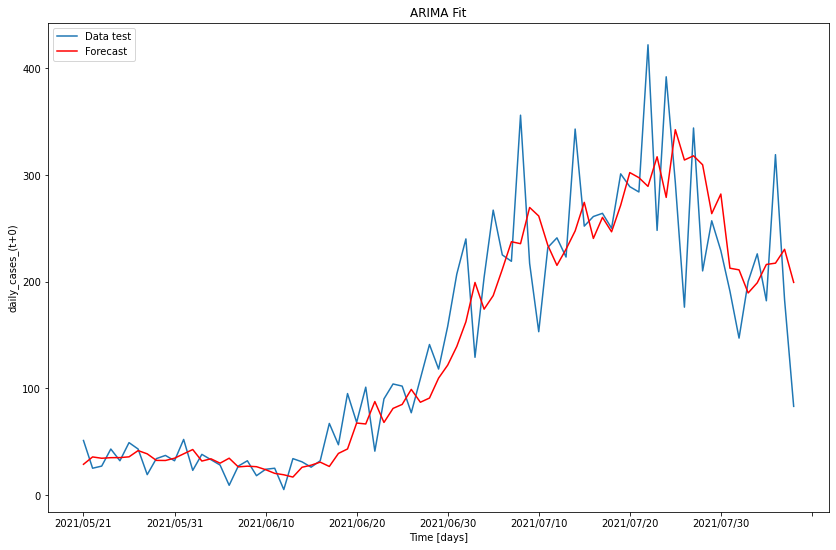

Elapsed time:  40.579272985458374 (s)


In [208]:
t0 = time.time()
arima_model(split_ndf, (4, 1, 2), True)
print('Elapsed time: ', time.time() - t0, '(s)')

The above predictions at each intant $t$ were calculated from the observations $(t=0,..., t-1)$ of the test dataset, i.e. a __one-step forecast__.

In [282]:
def multi_step_arima(splits, arima_order, time_step=7, graph=False):
    """
    Get a multi-step single-shot forecast for the last [time_step] days of test dataset. 
    Calculate RMSE, MSE, MAE, R2.
    Args:
        splits: Dictionary with training, validation and test data. 
        arima_order: Tuple. Contains the argument p, d, q for ARIMA model.
        time_step: Number of Step Out-of-Sample Forecast
        graph: Boolean. Plot the predictions and test dataset.

    Returns: None. Prints metrics and shows the graph.
    """
    try:
        # prepare training dataset
        train_y = splits['train']['y'].astype('float32')
        val_y = splits['val']['y'].astype('float32')
        test_y = splits['test']['y'].astype('float32')
        target = pd.concat([train_y, val_y, test_y])
        
        train_size = int(len(target) - time_step)
        train, test = target[0:train_size], target[train_size:]
        history = [x for x in train]
        
        # Define model
        model = sm.tsa.ARIMA(history, order=arima_order)
        model_fit = model.fit(dis=-1)
        # Forecast and metrics
        predictions = model_fit.forecast(steps=time_step)[0]
       
        # Metrics
        mse = mean_squared_error(test, predictions)
        rmse = sqrt(mean_squared_error(test, predictions))
        mae = mean_absolute_error(test, predictions)
        mape = mean_absolute_percentage_error(test, predictions)
        r2 = r2_score(test, predictions)

        metrics = {"RMSE": rmse,
                   "MSE": mse,
                   "MAE": mae,
                   "MAPE": mape,
                   "R2": r2}
        print(metrics)
        
        if graph:
            # plot forecasts against actual outcomes
            test.plot()
            plt.plot(predictions, color='red')
            plt.title('ARIMA Fit')
            plt.ylabel(target.name)
            plt.xlabel('Time [days]')
            plt.legend(['Data', 'Forecast'], loc='upper left')
            plt.show()
    
    except Exception as e:
        print(e)

{'RMSE': 68.35169196032214, 'MSE': 4671.953793838766, 'MAE': 55.43756134268056, 'MAPE': 0.40592523817626713, 'R2': -0.04040127272588534}


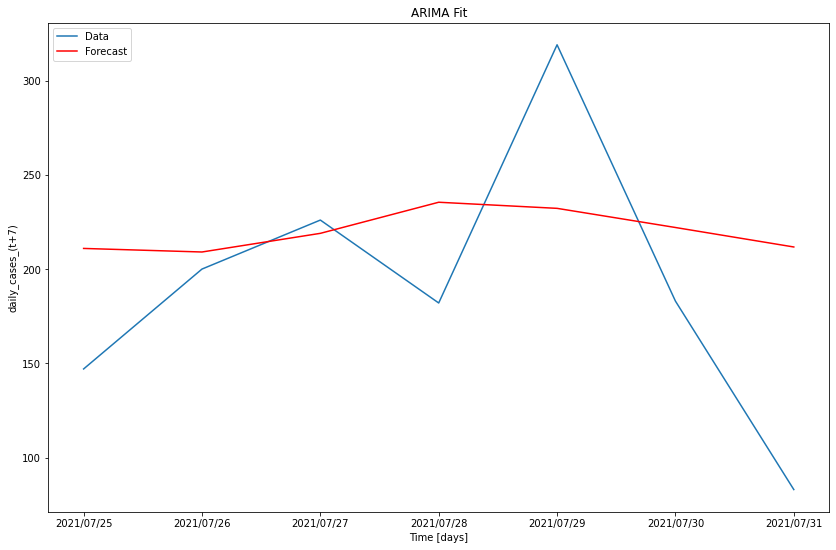

In [284]:
multi_step_arima(split_ndf, (4, 1, 2), time_step=7, graph=True)

ARIMA model is useful for multi-step time series forecasting:
* Single-shot: Make the predictions all at once.
* Autoregressive: Make one prediction at a time and feed the output back to the model.

In [285]:
def autoregressive_arima(splits, arima_order, time_step=7, graph=False):
    """
    Evaluate an ARIMA model for a given order (p,d,q) and forecast the next one time step.
    Autoregressive model: Train the model using t = (1, ..., t) and predict next time step (t+1).
    Then add (t+1) predicted value to history and fit again the model using t = (1, ..., t, t+1),
    and so on up to t=time_step.
    
    
    Args:
        splits: Dictionary with training, validation and test data. 
        arima_order: Tuple. Contains the argument p, d, q for ARIMA model.
        time_step: Number of Step Out-of-Sample Forecast
        graph: Boolean. Plot the predictions and test dataset.

    Returns: None. Prints metrics and shows the graph.
    """
    try:
        # prepare training dataset
        train_y = splits['train']['y'].astype('float32')
        val_y = splits['val']['y'].astype('float32')
        test_y = splits['test']['y'].astype('float32')
        target = pd.concat([train_y, val_y, test_y])
        
        train_size = int(len(target) - time_step)
        train, test = target[0:train_size], target[train_size:]
        history = [x for x in train]
        predictions = list()

        for t in range(len(test)):
            model = sm.tsa.ARIMA(history, order=arima_order)
            model_fit = model.fit(dis=-1)  # All cores
            yhat = model_fit.forecast(steps=1)[0]  # Predict one step in future from the last value in history variable.
            predictions.append(yhat)
            history.append(yhat)

        # Metrics
        mse = mean_squared_error(test, predictions)
        rmse = sqrt(mean_squared_error(test, predictions))
        mae = mean_absolute_error(test, predictions)
        mape = mean_absolute_percentage_error(test, predictions)
        r2 = r2_score(test, predictions)
        metrics = {"RMSE": rmse,
                   "MSE": mse,
                   "MAE": mae,
                   "MAPE": mape,
                   "R2": r2}
        print(metrics)
                
        if graph:
            # plot forecasts against actual outcomes
            test.plot()
            plt.plot(predictions, color='red')
            plt.title('ARIMA Fit')
            plt.ylabel(test.name)
            plt.xlabel('Time [days]')
            plt.legend(['Data test', 'Forecast'], loc='upper left')
            plt.show()
                
    except Exception as e:
        pass

{'RMSE': 68.34965381836398, 'MSE': 4671.6751770901965, 'MAE': 55.43638620471313, 'MAPE': 0.40591470236011135, 'R2': -0.04033922733061712}


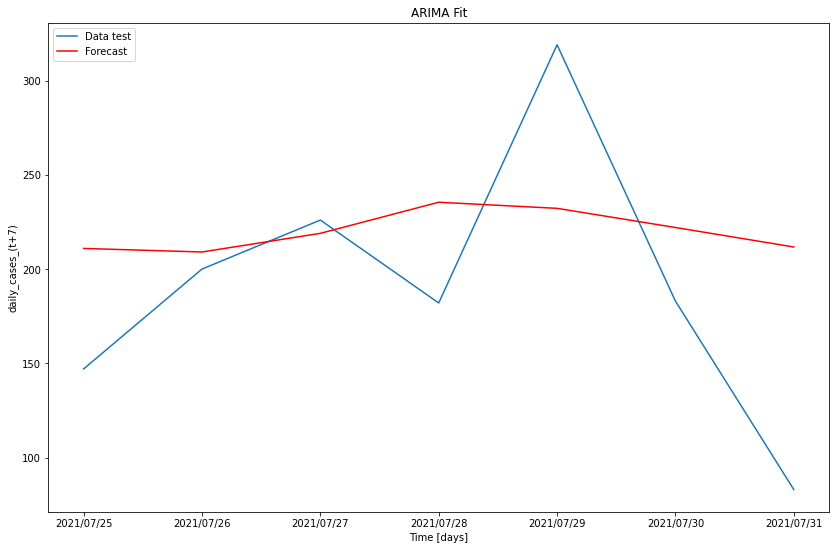

In [286]:
autoregressive_arima(split_ndf, (4, 1, 2), time_step=7, graph=True)